# Latent Dirichlet Allocation GridSearchCV Part 1: Coarse Search

In this notebook and the following Fine search, we consider appropriate parameters for constructing Latent Dirichlet Allocation topics from the matrix of user-product purchase counts.

[Helpful tutorial](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

## Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.latex.repr=True

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

file_path = '../input/'

load_data_dtype = {'order_id': np.uint32,
                   'user_id': np.uint32,
                   'eval_set': 'category',
                   'order_number': np.uint8,
                   'order_dow': np.uint8,
                   'order_hour_of_day': np.uint8,
                   # pandas 'gotcha'; leave as float:
                   'days_since_prior_order': np.float16,
                   'product_id': np.uint16,
                   'add_to_cart_order': np.uint8,
                   'reordered': np.bool
                   }

df_aisles = pd.read_csv(file_path + 'aisles.csv')
df_departments = pd.read_csv(file_path + 'departments.csv')
df_products = pd.read_csv(file_path + 'products.csv')

# Specify dtype to reduce memory utilization
df_order_products_prior = pd.read_csv(file_path + 'order_products__prior.csv',
                                      dtype=load_data_dtype
                                      )
df_order_products_train = pd.read_csv(file_path + 'order_products__train.csv',
                                      dtype=load_data_dtype
                                      )
df_orders = pd.read_csv(file_path + 'orders.csv',
                        dtype=load_data_dtype
                        )

# df_prior = full products from all prior orders 
df_prior = pd.merge(df_orders[df_orders['eval_set'] == 'prior'],
              df_order_products_prior,
              on='order_id'
              )

In [2]:
from sklearn.model_selection import train_test_split

# Names of dataset partitions
dsets = ['train',
         'test',
         'kaggle']

users = dict.fromkeys(dsets)

# Use sklearn utility to partition project users into train and test user lists.
users['train'], users['test'] = train_test_split(list(df_orders[df_orders.eval_set == 'train']['user_id']),
                                                 test_size=0.2,
                                           random_state=20190513)

# Kaggle submissions test set
users['kaggle'] = list(df_orders[df_orders.eval_set == 'test']['user_id'])#.to_list()

In [3]:
# Split DataFrames we will use in feature construction into dicts of DataFrames
prior = dict.fromkeys(dsets)
orders = dict.fromkeys(dsets)

for ds in dsets:
    prior[ds] = df_prior[df_prior['user_id'].isin(users[ds])]
    orders[ds] = df_orders[df_orders['user_id'].isin(users[ds]) & (df_orders.eval_set == 'prior')]

In [4]:
# scipy sparse matrix of number of times particular user has ordered particular product
UP_orders_num = dict.fromkeys(dsets)

for ds in dsets:
    UP_orders_num[ds], _, _ = (prior[ds].groupby(['user_id', 'product_id'])['order_id']
                             .count()
                             .apply(pd.to_numeric, downcast='unsigned')
                             .to_sparse()
                             .to_coo())

In [5]:
del (df_aisles,
     df_departments,
     df_order_products_prior,
     df_order_products_train,
     df_orders,
     df_prior,
     df_products,
     prior,
     orders)

## GridSearchCV

### n_components

In [6]:
param = 'n_components'
vals = [5, 10, 15, 20]

params = {
    param: vals
}

lda = LatentDirichletAllocation(n_jobs=1, # need more disk? PickleError
                                learning_method='online'
                               )

lda_search = GridSearchCV(lda,
                          param_grid=params,
                          cv=3,
                          return_train_score=False)

lda_search.fit(UP_orders_num['train'])

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

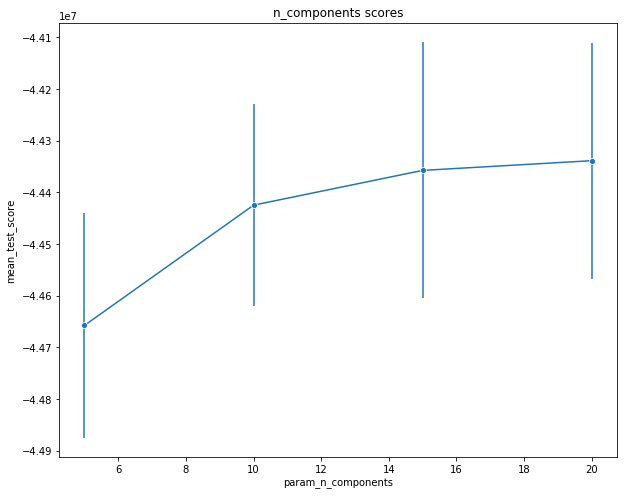

In [7]:
results = pd.DataFrame(lda_search.cv_results_)

current_palette = sns.color_palette()

plt.figure(figsize=(10,8))
sns.lineplot(data=results,
             x=('param_' + param),
             y='mean_test_score',
             marker='o')
plt.title(param + " scores")
plt.errorbar(x=results[('param_' + param)],
             y=results.mean_test_score,
             yerr=results.std_test_score,
             fmt='none',
             color=current_palette[0])
plt.show()

`n_components = 15` looks best though `n_components = 10` may be reasonable (and would only add ten columns to the feature matrix).

### max_iter

In [8]:
param = 'max_iter'
vals = [10, 20, 30]

params = {
    param: vals
}

lda = LatentDirichletAllocation(n_jobs=1, # need more disk? PickleError
                                learning_method='online',
                                # Choose values from above search
                                n_components=10
                               )

lda_search = GridSearchCV(lda,
                          param_grid=params,
                          cv=3,
                          return_train_score=False
                         )

lda_search.fit(UP_orders_num['train'])

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [10, 20, 30]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False, scoring=None, verbose=0)

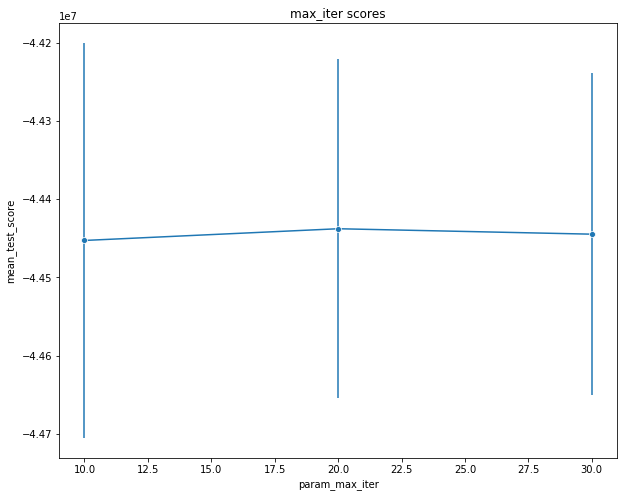

In [9]:
results = pd.DataFrame(lda_search.cv_results_)

current_palette = sns.color_palette()

plt.figure(figsize=(10,8))
sns.lineplot(data=results,
             x=('param_' + param),
             y='mean_test_score',
             marker='o')
plt.title(param + " scores")
plt.errorbar(x=results[('param_' + param)],
             y=results.mean_test_score,
             yerr=results.std_test_score,
             fmt='none',
             color=current_palette[0])
plt.show()

`max_iter` seems not to make a difference in score. Leave the default `max_iter = 10`.

### learning_decay

In [10]:
param = 'learning_decay'
vals = [.5, .7, .9]

params = {
    param: vals
}

lda = LatentDirichletAllocation(n_jobs=1, # need more disk? PickleError
                                learning_method='online',
                                # Choose values from above search
                                n_components=10,
                                max_iter=10                                
                               )



lda_search = GridSearchCV(lda,
                          param_grid=params,
                          cv=3,
                          return_train_score=False
                         )

lda_search.fit(UP_orders_num['train'])

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

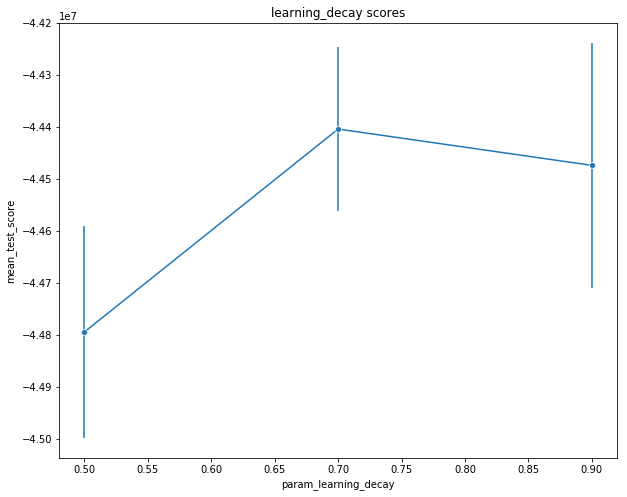

In [11]:
results = pd.DataFrame(lda_search.cv_results_)

current_palette = sns.color_palette()

plt.figure(figsize=(10,8))
sns.lineplot(data=results,
             x=('param_' + param),
             y='mean_test_score',
             marker='o')
plt.title(param + " scores")
plt.errorbar(x=results[('param_' + param)],
             y=results.mean_test_score,
             yerr=results.std_test_score,
             fmt='none',
             color=current_palette[0])
plt.show()

Somewhere between `learning_decay = 0.7` and `learning_decay = 0.9` looks to yield the best score.

Part 2 consists of a finer search near `learning_decay = 0.7` and `n_components = 10`. Stay tuned.